The data used in this notebook is era5 monthly mean air temp with height over the SA-CPRCM domain for the year 2001 https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels-monthly-means?tab=overview

In [1]:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import datetime
import shutil
from pathlib import Path
import trackpy
from iris.time import PartialDateTime
import cartopy.crs as ccrs
import xarray as xr
import netCDF4 as nc
import scipy
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure

#import packages that output memory usage:
#from sys import getsizeof

import tobac #tobac package cloned from https://github.com/tobac-project/tobac.git

import warnings
warnings.filterwarnings('ignore')

In [2]:
## load in filenames for whole domian tropopause temp mean
trop_temp_2001 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_2001.txt')
trop_temp_2001 = trop_temp_2001.drop(columns='Unnamed: 0')
trop_temp_values_2001 = trop_temp_2001.values.tolist()
trop_temp_values_2001

[[194.24048],
 [193.60753],
 [194.33684],
 [195.57866],
 [197.30995],
 [198.5828],
 [200.1095],
 [200.66974],
 [200.11002],
 [198.39929],
 [196.12515],
 [194.83647]]

In [3]:
trop_temp_2002 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_2002.txt')
trop_temp_2002 = trop_temp_2002.drop(columns='Unnamed: 0')
trop_temp_2002.replace(0, np.nan, inplace=True)
trop_temp_values_2002 = trop_temp_2002.values.tolist()
trop_temp_values_2002

[[194.44771],
 [194.58475],
 [194.6526],
 [196.05219],
 [197.88588],
 [199.42256],
 [200.39459],
 [199.407],
 [198.50227],
 [196.7232],
 [nan],
 [194.62871]]

In [4]:
trop_temp_2003 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_2003.txt')
trop_temp_2003 = trop_temp_2003.drop(columns='Unnamed: 0')
trop_temp_values_2003 = trop_temp_2003.values.tolist()
trop_temp_values_2003

[[196.33716],
 [195.4774],
 [197.74536],
 [199.07664],
 [200.27759],
 [201.63498],
 [202.44283],
 [203.43187],
 [202.20995],
 [200.81693],
 [199.36064],
 [197.08765]]

In [5]:
trop_temp_2004 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_2004.txt')
trop_temp_2004 = trop_temp_2004.drop(columns='Unnamed: 0')
trop_temp_values_2004 = trop_temp_2004.values.tolist()
trop_temp_values_2004

[[195.65097],
 [197.11151],
 [196.73372],
 [198.29521],
 [199.06973],
 [199.46455],
 [202.11722],
 [203.42793],
 [202.3223],
 [200.95853],
 [198.72559],
 [198.52985]]

In [6]:
trop_temp_2005 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_2005.txt')
trop_temp_2005 = trop_temp_2005.drop(columns='Unnamed: 0')
trop_temp_values_2005 = trop_temp_2005.values.tolist()
trop_temp_values_2005

[[196.77975],
 [197.30667],
 [197.56566],
 [197.50092],
 [198.90585],
 [200.61342],
 [202.93793],
 [202.66295],
 [203.11198],
 [201.68471],
 [199.69083],
 [196.96918]]

In [7]:
trop_temp_2006 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_2006.txt')
trop_temp_2006 = trop_temp_2006.drop(columns='Unnamed: 0')
trop_temp_values_2006 = trop_temp_2006.values.tolist()
trop_temp_values_2006

[[195.87825],
 [196.92505],
 [197.30058],
 [197.00613],
 [197.86133],
 [200.14723],
 [200.81847],
 [202.06578],
 [202.21976],
 [200.28476],
 [198.02242],
 [197.47485]]

In [8]:
trop_temp_2007 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_2007.txt')
trop_temp_2007 = trop_temp_2007.drop(columns='Unnamed: 0')
trop_temp_values_2007 = trop_temp_2007.values.tolist()
trop_temp_values_2007

[[196.59795],
 [196.42996],
 [197.39546],
 [198.13484],
 [198.93716],
 [201.27733],
 [202.41644],
 [203.26187],
 [202.50641],
 [200.05298],
 [198.42058],
 [197.64113]]

In [9]:
## Load in ERA5 data 
filename_obs_2001 = '/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/era5_air_temp_w_height_2001.nc'

obs_airtemp_2001 = xr.open_dataset(filename_obs_2001)

obs_airtemp_2001 = obs_airtemp_2001.t

dy_2001 = obs_airtemp_2001.groupby('time').mean('longitude') ##zonal mean at each time and height
dz_2001 = dy_2001.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

## LOOP TO FIND THE TROPOAUSE TEMP FOR ERA5 ##

mean_trop_temp_obs_2001 = []

for month in np.arange(0,12):
    subset = dz_2001.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min)
    mean_trop_temp_obs_2001.append(float(min))

mean_trop_temp_obs_2001

195.28645
194.8638
195.34857
196.2358
197.34549
199.19095
200.43205
200.62376
200.39911
198.17285
196.19205
195.94891


[195.2864532470703,
 194.86380004882812,
 195.34857177734375,
 196.2357940673828,
 197.34548950195312,
 199.19094848632812,
 200.4320526123047,
 200.62376403808594,
 200.39910888671875,
 198.1728515625,
 196.19204711914062,
 195.94891357421875]

In [10]:
filename_obs = '/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/era5_vertical_airtemp_2002_2007.nc'

obs_airtemp = xr.open_dataset(filename_obs)

obs_airtemp = obs_airtemp.t

obs_airtemp_2002 = obs_airtemp.sel(time=obs_airtemp.time.dt.year.isin([2002]))
obs_airtemp_2003 = obs_airtemp.sel(time=obs_airtemp.time.dt.year.isin([2003]))
obs_airtemp_2004 = obs_airtemp.sel(time=obs_airtemp.time.dt.year.isin([2004]))
obs_airtemp_2005 = obs_airtemp.sel(time=obs_airtemp.time.dt.year.isin([2005]))
obs_airtemp_2006 = obs_airtemp.sel(time=obs_airtemp.time.dt.year.isin([2006]))
obs_airtemp_2007 = obs_airtemp.sel(time=obs_airtemp.time.dt.year.isin([2007]))

In [11]:
dy_2002 = obs_airtemp_2002.groupby('time').mean('longitude') ##zonal mean at each time and height
dz_2002 = dy_2002.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

mean_trop_temp_obs_2002 = []

for month in np.arange(0,12):
    subset = dz_2002.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min)
    mean_trop_temp_obs_2002.append(float(min))

195.27621
195.391
195.16855
195.69118
198.4468
199.63802
200.72423
199.76036
198.3817
196.49538
196.12111
195.34595


In [12]:
dy_2003 = obs_airtemp_2003.groupby('time').mean('longitude') ##zonal mean at each time and height
dz_2003 = dy_2003.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

mean_trop_temp_obs_2003 = []

for month in np.arange(0,12):
    subset = dz_2003.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min)
    mean_trop_temp_obs_2003.append(float(min))

195.37808
195.2501
195.3862
196.6029
198.39586
198.85692
200.24968
200.44418
199.75052
197.38339
196.76471
195.54564


In [13]:
dy_2004 = obs_airtemp_2004.groupby('time').mean('longitude') ##zonal mean at each time and height
dz_2004 = dy_2004.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

mean_trop_temp_obs_2004 = []

for month in np.arange(0,12):
    subset = dz_2004.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min)
    mean_trop_temp_obs_2004.append(float(min))

194.89546
196.0566
196.0173
195.83537
197.5077
199.49463
200.04486
199.86902
198.79266
197.60637
196.5452
196.27478


In [14]:
dy_2005 = obs_airtemp_2005.groupby('time').mean('longitude') ##zonal mean at each time and height
dz_2005 = dy_2005.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

mean_trop_temp_obs_2005 = []

for month in np.arange(0,12):
    subset = dz_2005.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min)
    mean_trop_temp_obs_2005.append(float(min))

195.13872
195.66519
195.34865
196.50725
197.12398
198.61302
199.74103
200.06148
200.04427
197.33809
196.02269
196.0018


In [15]:
dy_2006 = obs_airtemp_2006.groupby('time').mean('longitude') ##zonal mean at each time and height
dz_2006 = dy_2006.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

mean_trop_temp_obs_2006 = []

for month in np.arange(0,12):
    subset = dz_2006.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min)
    mean_trop_temp_obs_2006.append(float(min))

194.76332
195.31529
194.47246
196.17969
197.78069
199.58105
200.4549
200.45886
200.48537
198.15692
196.94658
196.64427


In [16]:
dy_2007 = obs_airtemp_2007.groupby('time').mean('longitude') ##zonal mean at each time and height
dz_2007 = dy_2007.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

mean_trop_temp_obs_2007 = []

for month in np.arange(0,12):
    subset = dz_2007.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min)
    mean_trop_temp_obs_2007.append(float(min))

196.47864
195.69244
195.7182
196.33578
198.09824
200.21504
200.79617
200.53824
199.28491
198.05652
196.65268
196.39984


In [17]:
## MEAN OF ALL YEARS TOGETHER ##

mean_obs = pd.DataFrame(columns=['2001','2002','2003','2004','2005','2006','2007'], index=range(1, 13))
mean_cpm = pd.DataFrame(columns=['2001','2002','2003','2004','2005','2006','2007'], index=range(1, 13))

In [18]:
## MEAN OF ALL YEARS TOGETHER ##

mean_obs = pd.DataFrame(columns=['2001','2002','2003','2004','2005','2006','2007'], index=range(1, 13))
mean_cpm = pd.DataFrame(columns=['2001','2002','2003','2004','2005','2006','2007'], index=range(1, 13))

mean_obs['2001'] = mean_trop_temp_obs_2001
mean_obs['2002'] = mean_trop_temp_obs_2002
mean_obs['2003'] = mean_trop_temp_obs_2003
mean_obs['2004'] = mean_trop_temp_obs_2004
mean_obs['2005'] = mean_trop_temp_obs_2005
mean_obs['2006'] = mean_trop_temp_obs_2006
mean_obs['2007'] = mean_trop_temp_obs_2007

mean_obs['mean']=mean_obs.mean(axis=1)


In [19]:
mean_obs['mean']=mean_obs.mean(axis=1)

In [20]:
mean_cpm['2001'] = np.array(trop_temp_values_2001)
mean_cpm['2002'] = np.array(trop_temp_values_2002)
mean_cpm['2003'] = np.array(trop_temp_values_2003)
mean_cpm['2004'] = np.array(trop_temp_values_2004)
mean_cpm['2005'] = np.array(trop_temp_values_2005)
mean_cpm['2006'] = np.array(trop_temp_values_2006)
mean_cpm['2007'] = np.array(trop_temp_values_2007)

In [21]:
mean_cpm['mean']=mean_cpm.mean(axis=1)

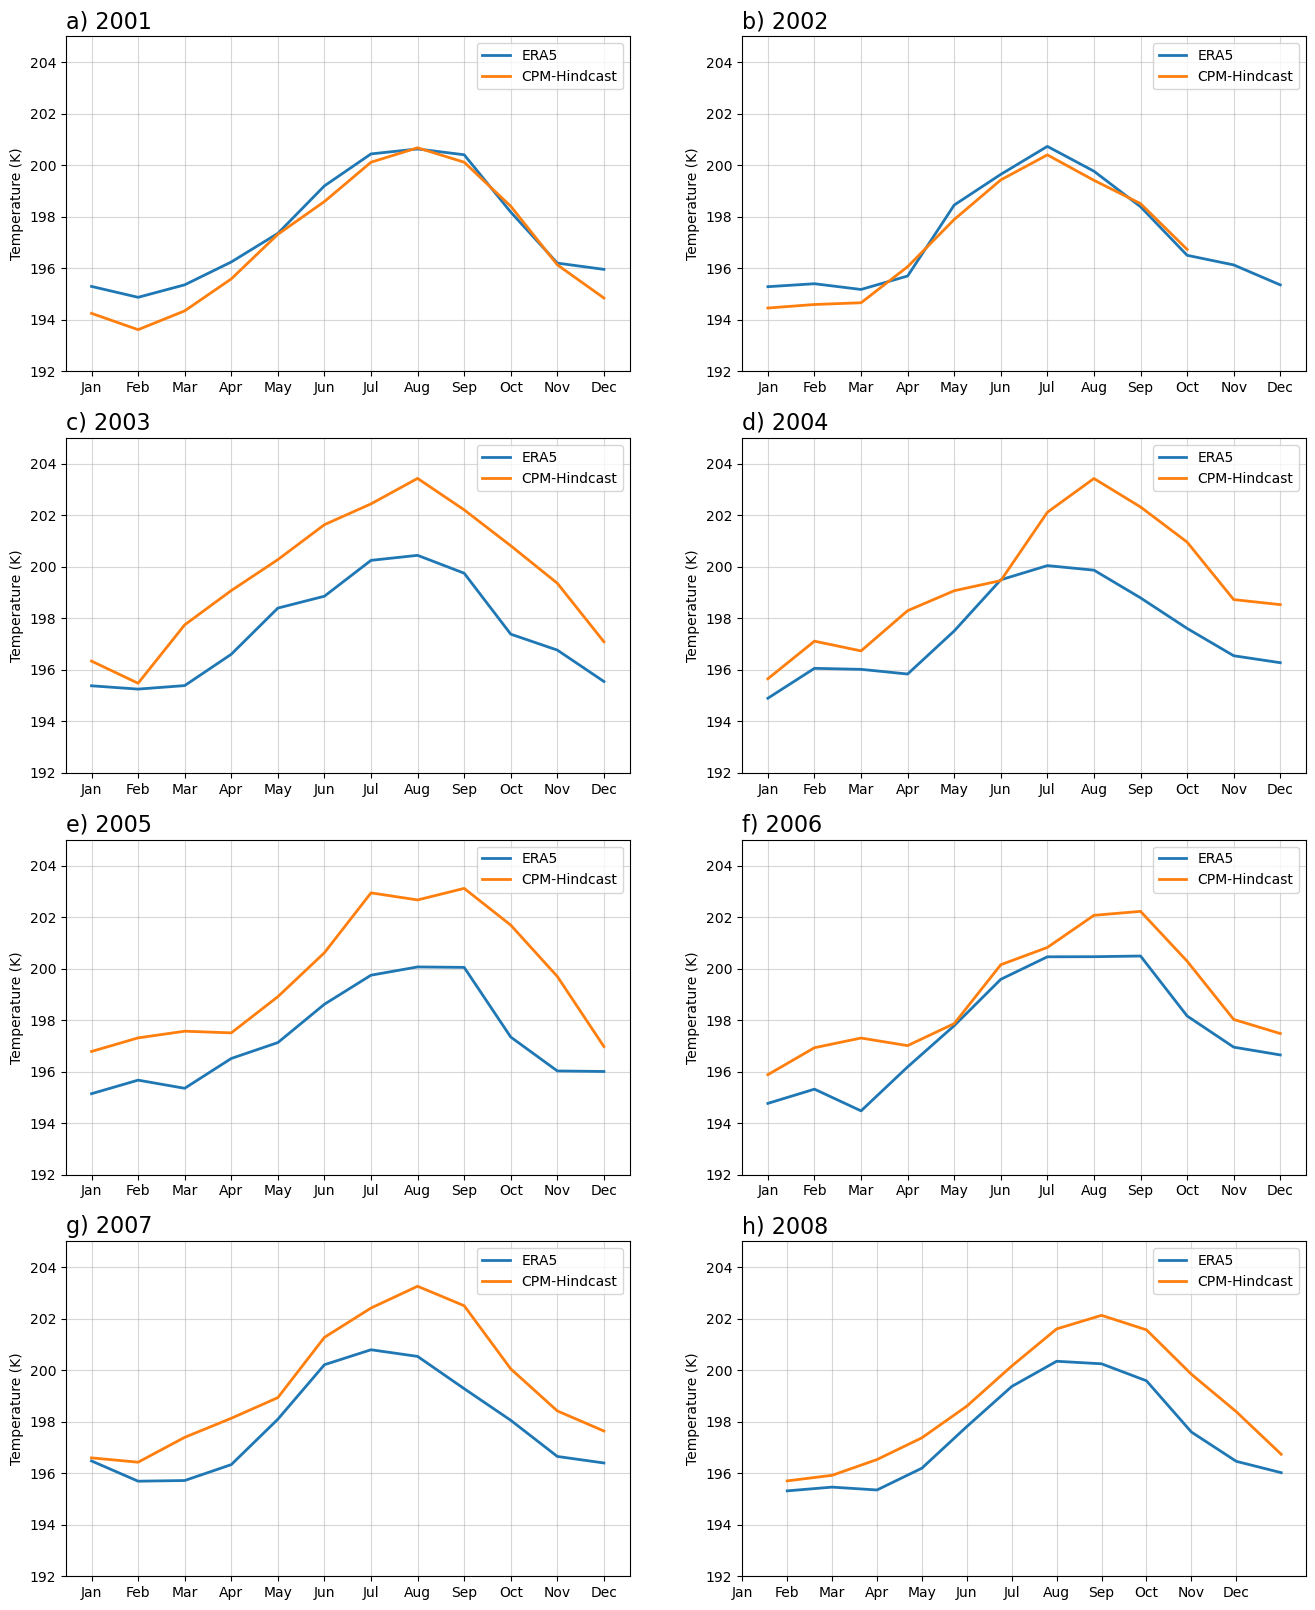

In [22]:
## Figure 

import matplotlib
matplotlib.rc_file_defaults()

plt.figure(figsize=(16,20))
f= 30
lf= 35
l=32

ax1 = plt.subplot(4, 2, 1) 
ax1.plot(mean_trop_temp_obs_2001, label='ERA5', linewidth=2)
ax1.plot(trop_temp_values_2001, label='CPM-Hindcast', linewidth=2)
ax1.set_title('a) 2001', fontsize=16, loc='left')
ax1.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax1.set_ylabel('Temperature (K)')
ax1.set_ylim(192,205)
ax1.legend(loc='best')
ax1.grid(alpha=0.5)

ax2 = plt.subplot(4, 2, 2) 
ax2.plot(mean_trop_temp_obs_2002, label='ERA5', linewidth=2)
ax2.plot(trop_temp_values_2002, label='CPM-Hindcast', linewidth=2)
ax2.set_title('b) 2002', fontsize=16, loc='left')
ax2.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax2.set_ylabel('Temperature (K)')
ax2.set_ylim(192,205)
ax2.legend(loc='best')
ax2.grid(alpha=0.5)

ax3 = plt.subplot(4, 2, 3) 
ax3.plot(mean_trop_temp_obs_2003, label='ERA5', linewidth=2)
ax3.plot(trop_temp_values_2003, label='CPM-Hindcast', linewidth=2)
ax3.set_title('c) 2003', fontsize=16, loc='left')
ax3.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax3.set_ylabel('Temperature (K)')
ax3.set_ylim(192,205)
ax3.legend(loc='best')
ax3.grid(alpha=0.5)

ax4 = plt.subplot(4, 2, 4) 
ax4.plot(mean_trop_temp_obs_2004, label='ERA5', linewidth=2)
ax4.plot(trop_temp_values_2004, label='CPM-Hindcast', linewidth=2)
ax4.set_title('d) 2004', fontsize=16, loc='left')
ax4.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax4.set_ylabel('Temperature (K)')
ax4.set_ylim(192,205)
ax4.legend(loc='best')
ax4.grid(alpha=0.5)

ax5 = plt.subplot(4, 2, 5) 
ax5.plot(mean_trop_temp_obs_2005, label='ERA5', linewidth=2)
ax5.plot(trop_temp_values_2005, label='CPM-Hindcast', linewidth=2)
ax5.set_title('e) 2005', fontsize=16, loc='left')
ax5.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax5.set_ylabel('Temperature (K)')
ax5.set_ylim(192,205)
ax5.legend(loc='best')
ax5.grid(alpha=0.5)

ax6 = plt.subplot(4, 2, 6) 
ax6.plot(mean_trop_temp_obs_2006, label='ERA5', linewidth=2)
ax6.plot(trop_temp_values_2006, label='CPM-Hindcast', linewidth=2)
ax6.set_title('f) 2006', fontsize=16, loc='left')
ax6.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax6.set_ylabel('Temperature (K)')
ax6.set_ylim(192,205)
ax6.legend(loc='best')
ax6.grid(alpha=0.5)


ax7 = plt.subplot(4, 2, 7) 
ax7.plot(mean_trop_temp_obs_2007, label='ERA5', linewidth=2)
ax7.plot(trop_temp_values_2007, label='CPM-Hindcast', linewidth=2)
ax7.set_title('g) 2007', fontsize=16, loc='left')
ax7.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax7.set_ylabel('Temperature (K)')
ax7.set_ylim(192,205)
ax7.legend(loc='best')
ax7.grid(alpha=0.5)

ax8 = plt.subplot(4, 2, 8) 
ax8.plot(mean_obs['mean'], label='ERA5', linewidth=2)
ax8.plot(mean_cpm['mean'], label='CPM-Hindcast', linewidth=2)
ax8.set_title('h) 2008', fontsize=16, loc='left')
ax8.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax8.set_ylabel('Temperature (K)')
ax8.set_ylim(192,205)
ax8.legend(loc='best')
ax8.grid(alpha=0.5)




Load in data for tropics and subtropics separately

In [23]:
trop_temp_tropics_2001 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_TROPICS2001.txt')
trop_temp_tropics_2001 = trop_temp_tropics_2001.drop(columns='Unnamed: 0')
trop_temp_values_tropics_2001 = trop_temp_tropics_2001.values.tolist()
trop_temp_values_tropics_2001

trop_temp_subtropics_2001 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_SUBTROPICS2001.txt')
trop_temp_subtropics_2001 = trop_temp_subtropics_2001.drop(columns='Unnamed: 0')
trop_temp_values_subtropics_2001 = trop_temp_subtropics_2001.values.tolist()
trop_temp_values_subtropics_2001


[[199.42575],
 [198.40579],
 [200.36864],
 [202.47395],
 [205.3985],
 [205.06631],
 [207.27823],
 [207.60974],
 [208.35199],
 [206.19917],
 [204.25095],
 [203.51843]]

In [24]:
trop_temp_tropics_2003 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_TROPICS2003.txt')
trop_temp_tropics_2003 = trop_temp_tropics_2003.drop(columns='Unnamed: 0')
trop_temp_values_tropics_2003 = trop_temp_tropics_2003.values.tolist()
trop_temp_values_tropics_2003

trop_temp_subtropics_2003 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_SUBTROPICS2003.txt')
trop_temp_subtropics_2003 = trop_temp_subtropics_2003.drop(columns='Unnamed: 0')
trop_temp_values_subtropics_2003 = trop_temp_subtropics_2003.values.tolist()
trop_temp_values_subtropics_2003

[[201.52148],
 [200.89307],
 [202.51857],
 [204.53882],
 [206.45476],
 [207.35944],
 [208.7035],
 [210.50446],
 [209.2255],
 [207.23677],
 [206.031],
 [202.96477]]

In [25]:
trop_temp_tropics_2004 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_TROPICS2004.txt')
trop_temp_tropics_2004 = trop_temp_tropics_2004.drop(columns='Unnamed: 0')
trop_temp_values_tropics_2004 = trop_temp_tropics_2004.values.tolist()
trop_temp_values_tropics_2004

trop_temp_subtropics_2004 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_SUBTROPICS2004.txt')
trop_temp_subtropics_2004 = trop_temp_subtropics_2004.drop(columns='Unnamed: 0')
trop_temp_values_subtropics_2004 = trop_temp_subtropics_2004.values.tolist()
trop_temp_values_subtropics_2004

[[202.14087],
 [203.69131],
 [202.55647],
 [204.20735],
 [205.96867],
 [206.43147],
 [208.17914],
 [210.63783],
 [209.3441],
 [208.65248],
 [205.08194],
 [205.58588]]

In [26]:
trop_temp_tropics_2005 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_TROPICS2005.txt')
trop_temp_tropics_2005 = trop_temp_tropics_2005.drop(columns='Unnamed: 0')
trop_temp_values_tropics_2005 = trop_temp_tropics_2005.values.tolist()
trop_temp_values_tropics_2005

trop_temp_subtropics_2005 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_SUBTROPICS2005.txt')
trop_temp_subtropics_2005 = trop_temp_subtropics_2005.drop(columns='Unnamed: 0')
trop_temp_values_subtropics_2005 = trop_temp_subtropics_2005.values.tolist()
trop_temp_values_subtropics_2005

[[200.94762],
 [202.84464],
 [203.10641],
 [203.82631],
 [205.3873],
 [206.66393],
 [209.55144],
 [208.95671],
 [209.84052],
 [208.271],
 [206.46153],
 [204.2575]]

In [27]:
trop_temp_tropics_2006 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_TROPICS2006.txt')
trop_temp_tropics_2006 = trop_temp_tropics_2006.drop(columns='Unnamed: 0')
trop_temp_values_tropics_2006 = trop_temp_tropics_2006.values.tolist()
trop_temp_values_tropics_2006

trop_temp_subtropics_2006 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_SUBTROPICS2006.txt')
trop_temp_subtropics_2006 = trop_temp_subtropics_2006.drop(columns='Unnamed: 0')
trop_temp_values_subtropics_2006 = trop_temp_subtropics_2006.values.tolist()
trop_temp_values_subtropics_2006

[[201.11667],
 [201.94244],
 [203.5156],
 [202.67383],
 [204.37273],
 [205.86305],
 [206.79875],
 [208.49585],
 [208.91713],
 [207.78026],
 [205.33247],
 [202.58698]]

In [28]:
trop_temp_tropics_2007 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_TROPICS2007.txt')
trop_temp_tropics_2007 = trop_temp_tropics_2007.drop(columns='Unnamed: 0')
trop_temp_values_tropics_2007 = trop_temp_tropics_2007.values.tolist()
trop_temp_values_tropics_2007

trop_temp_subtropics_2007 = pd.read_csv('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_hindcast_monthly_mean_airtemp_SUBTROPICS2007.txt')
trop_temp_subtropics_2007 = trop_temp_subtropics_2007.drop(columns='Unnamed: 0')
trop_temp_values_subtropics_2007 = trop_temp_subtropics_2007.values.tolist()
trop_temp_values_subtropics_2007

[[202.3671],
 [201.05544],
 [202.718],
 [203.47298],
 [205.48793],
 [207.34183],
 [209.22429],
 [208.60774],
 [208.86543],
 [207.18967],
 [204.90839],
 [202.90813]]

In [29]:
## process tropics and subtropics for era5 data
tropics_2001 = obs_airtemp_2001[:,:,:141,:] ## Subsetting for tropics (15N - 20S)
subtropics_2001 = obs_airtemp_2001[:,:,141:,:] ## Subsetting for subtropics (20S - 40S)

tropics_2002 = obs_airtemp_2002[:,:,:141,:] ## Subsetting for tropics (15N - 20S)
subtropics_2002 = obs_airtemp_2002[:,:,141:,:] ## Subsetting for subtropics (20S - 40S)

tropics_2003 = obs_airtemp_2003[:,:,:141,:] ## Subsetting for tropics (15N - 20S)
subtropics_2003 = obs_airtemp_2003[:,:,141:,:] ## Subsetting for subtropics (20S - 40S)

tropics_2004 = obs_airtemp_2004[:,:,:141,:] ## Subsetting for tropics (15N - 20S)
subtropics_2004 = obs_airtemp_2004[:,:,141:,:] ## Subsetting for subtropics (20S - 40S)

tropics_2005 = obs_airtemp_2005[:,:,:141,:] ## Subsetting for tropics (15N - 20S)
subtropics_2005 = obs_airtemp_2005[:,:,141:,:] ## Subsetting for subtropics (20S - 40S)

tropics_2006 = obs_airtemp_2006[:,:,:141,:] ## Subsetting for tropics (15N - 20S)
subtropics_2006 = obs_airtemp_2006[:,:,141:,:] ## Subsetting for subtropics (20S - 40S)

tropics_2007 = obs_airtemp_2007[:,:,:141,:] ## Subsetting for tropics (15N - 20S)
subtropics_2007 = obs_airtemp_2007[:,:,141:,:] ## Subsetting for subtropics (20S - 40S)

In [30]:
tropics_y_2001 = tropics_2001.groupby('time').mean('longitude') ##zonal mean at each time and height
tropics_z_2001 = tropics_y_2001.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

trop_temp_tropics_2001 = []

for month in np.arange(0,12):
    subset = tropics_z_2001.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    trop_temp_tropics_2001.append(float(min))


subtropics_y_2001 = subtropics_2001.groupby('time').mean('longitude') ##zonal mean at each time and height
subtropics_z_2001 = subtropics_y_2001.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

trop_temp_subtropics_2001 = []

for month in np.arange(0,12):
    subset = subtropics_z_2001.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    trop_temp_subtropics_2001.append(float(min))

In [84]:
np.array(trop_temp_subtropics_2001)

array([200.02307129, 198.43371582, 200.84106445, 202.79901123,
       205.71113586, 205.18278503, 207.12138367, 207.89201355,
       208.53144836, 206.52055359, 204.67796326, 203.82470703])

In [31]:
tropics_y_2002 = tropics_2002.groupby('time').mean('longitude') ##zonal mean at each time and height
tropics_z_2002 = tropics_y_2002.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

trop_temp_tropics_2002 = []

for month in np.arange(0,12):
    subset = tropics_z_2002.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    trop_temp_tropics_2002.append(float(min))


subtropics_y_2002 = subtropics_2002.groupby('time').mean('longitude') ##zonal mean at each time and height
subtropics_z_2002 = subtropics_y_2002.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

trop_temp_subtropics_2002 = []

for month in np.arange(0,12):
    subset = subtropics_z_2002.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    trop_temp_subtropics_2002.append(float(min))

In [32]:
tropics_y_2003 = tropics_2003.groupby('time').mean('longitude') ##zonal mean at each time and height
tropics_z_2003 = tropics_y_2003.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

trop_temp_tropics_2003 = []

for month in np.arange(0,12):
    subset = tropics_z_2003.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    trop_temp_tropics_2003.append(float(min))


subtropics_y_2003 = subtropics_2003.groupby('time').mean('longitude') ##zonal mean at each time and height
subtropics_z_2003 = subtropics_y_2003.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

trop_temp_subtropics_2003 = []

for month in np.arange(0,12):
    subset = subtropics_z_2003.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    trop_temp_subtropics_2003.append(float(min))

In [33]:
tropics_y_2004 = tropics_2004.groupby('time').mean('longitude') ##zonal mean at each time and height
tropics_z_2004 = tropics_y_2004.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

trop_temp_tropics_2004 = []

for month in np.arange(0,12):
    subset = tropics_z_2004.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    trop_temp_tropics_2004.append(float(min))


subtropics_y_2004 = subtropics_2004.groupby('time').mean('longitude') ##zonal mean at each time and height
subtropics_z_2004 = subtropics_y_2004.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

trop_temp_subtropics_2004 = []

for month in np.arange(0,12):
    subset = subtropics_z_2004.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    trop_temp_subtropics_2004.append(float(min))

In [34]:
tropics_y_2005 = tropics_2005.groupby('time').mean('longitude') ##zonal mean at each time and height
tropics_z_2005 = tropics_y_2005.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

trop_temp_tropics_2005 = []

for month in np.arange(0,12):
    subset = tropics_z_2005.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    trop_temp_tropics_2005.append(float(min))


subtropics_y_2005 = subtropics_2005.groupby('time').mean('longitude') ##zonal mean at each time and height
subtropics_z_2005 = subtropics_y_2005.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

trop_temp_subtropics_2005 = []

for month in np.arange(0,12):
    subset = subtropics_z_2005.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    trop_temp_subtropics_2005.append(float(min))

In [35]:
tropics_y_2006 = tropics_2006.groupby('time').mean('longitude') ##zonal mean at each time and height
tropics_z_2006 = tropics_y_2006.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

trop_temp_tropics_2006 = []

for month in np.arange(0,12):
    subset = tropics_z_2006.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    trop_temp_tropics_2006.append(float(min))


subtropics_y_2006 = subtropics_2006.groupby('time').mean('longitude') ##zonal mean at each time and height
subtropics_z_2006 = subtropics_y_2006.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

trop_temp_subtropics_2006 = []

for month in np.arange(0,12):
    subset = subtropics_z_2006.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    trop_temp_subtropics_2006.append(float(min))

In [36]:
tropics_y_2007 = tropics_2007.groupby('time').mean('longitude') ##zonal mean at each time and height
tropics_z_2007 = tropics_y_2007.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

trop_temp_tropics_2007 = []

for month in np.arange(0,12):
    subset = tropics_z_2007.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    trop_temp_tropics_2007.append(float(min))


subtropics_y_2007 = subtropics_2007.groupby('time').mean('longitude') ##zonal mean at each time and height
subtropics_z_2007 = subtropics_y_2007.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

trop_temp_subtropics_2007 = []

for month in np.arange(0,12):
    subset = subtropics_z_2007.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    trop_temp_subtropics_2007.append(float(min))

In [64]:
## mean of all years together for tropics and subtropics separately

mean_obs_tropics = pd.DataFrame(columns=['2001','2002','2003','2004','2005','2006','2007'], index=range(1, 13))
mean_obs_subtropics = pd.DataFrame(columns=['2001','2002','2003','2004','2005','2006','2007'], index=range(1, 13))
mean_cpm_tropics = pd.DataFrame(columns=['2001','2002','2003','2004','2005','2006','2007'], index=range(1, 13))
mean_cpm_subtropics = pd.DataFrame(columns=['2001','2002','2003','2004','2005','2006','2007'], index=range(1, 13))

mean_obs_tropics['2001'] = trop_temp_tropics_2001
mean_obs_tropics['2002'] = trop_temp_tropics_2002
mean_obs_tropics['2003'] = trop_temp_tropics_2003
mean_obs_tropics['2004'] = trop_temp_tropics_2004
mean_obs_tropics['2005'] = trop_temp_tropics_2005
mean_obs_tropics['2006'] = trop_temp_tropics_2006
mean_obs_tropics['2007'] = trop_temp_tropics_2007

mean_obs_tropics['mean']=mean_obs_tropics.mean(axis=1)

In [65]:
mean_obs_subtropics['2001'] = trop_temp_subtropics_2001
mean_obs_subtropics['2002'] = trop_temp_subtropics_2002
mean_obs_subtropics['2003'] = trop_temp_subtropics_2003
mean_obs_subtropics['2004'] = trop_temp_subtropics_2004
mean_obs_subtropics['2005'] = trop_temp_subtropics_2005
mean_obs_subtropics['2006'] = trop_temp_subtropics_2006
mean_obs_subtropics['2007'] = trop_temp_subtropics_2007

mean_obs_subtropics['mean']=mean_obs_subtropics.mean(axis=1)

mean_obs_subtropics

,2001,2002,2003,2004,2005,2006,2007,mean
1,200.023071,199.840897,199.939163,200.817993,200.172012,200.054840,200.846680,200.242094
2,198.433716,201.964752,199.652557,202.826859,202.246628,201.288574,200.143463,200.936650
3,200.841064,199.869171,200.798309,202.741623,200.999573,200.384064,200.327103,200.851558
4,202.799011,202.188354,203.873260,202.482025,203.701813,203.962494,202.681976,203.098419
5,205.711136,205.496292,206.139160,205.513885,204.435196,206.284027,205.921829,205.643075
6,205.182785,205.967377,204.700226,205.828659,205.718781,206.694534,206.461334,205.793385
7,207.121384,207.789429,206.690018,205.884857,206.232132,206.910919,208.375931,207.000667
8,207.892014,205.728836,207.316360,206.652008,206.448395,207.582855,207.766357,207.055261
9,208.531448,204.988968,206.825684,204.012207,208.137726,207.372849,205.548141,206.488146
10,206.520554,201.529037,204.596222,204.670807,203.981079,205.192108,204.937454,204.489609


In [91]:
mean_cpm_tropics['2001'] = np.array(trop_temp_values_tropics_2001)
mean_cpm_tropics['2002'] = np.nan
mean_cpm_tropics['2003'] = np.array(trop_temp_values_tropics_2003)
mean_cpm_tropics['2004'] = np.array(trop_temp_values_tropics_2004)
mean_cpm_tropics['2005'] = np.array(trop_temp_values_tropics_2005)
mean_cpm_tropics['2006'] = np.array(trop_temp_values_tropics_2006)
mean_cpm_tropics['2007'] = np.array(trop_temp_values_tropics_2007)
mean_cpm_tropics['mean'] = mean_cpm_tropics.mean(axis=1)
mean_cpm_tropics


,2001,2002,2003,2004,2005,2006,2007,mean
1,191.26372,NaN,193.36098,191.79535,194.38707,192.70180,193.28604,193.125349
2,190.84776,NaN,192.36842,193.23361,193.97032,194.04470,193.72437,193.296594
3,190.87413,NaN,195.00516,193.39104,194.28864,193.73271,194.33994,193.956346
4,191.62029,NaN,195.94092,194.90118,193.86967,193.59833,194.98506,194.557170
5,192.66652,NaN,196.53366,195.00130,194.92400,193.90993,195.00914,195.165554
6,194.86078,NaN,198.08327,195.26938,196.99721,196.58359,197.55632,196.945086
7,195.99414,NaN,198.67700,198.33295,198.84193,197.18478,198.20503,198.288475
8,196.68565,NaN,199.26682,199.15000,198.89690,198.36957,199.76230,199.105067
9,195.37851,NaN,198.06600,198.16699,199.17763,198.19667,198.78372,198.445725
10,193.83717,NaN,197.08467,196.47150,197.81107,195.66832,195.95432,196.608578


In [88]:
mean_cpm_subtropics['2001'] = np.array(trop_temp_values_subtropics_2001)
mean_cpm_subtropics['2002'] = np.nan
mean_cpm_subtropics['2003'] = np.array(trop_temp_values_subtropics_2003)
mean_cpm_subtropics['2004'] = np.array(trop_temp_values_subtropics_2004)
mean_cpm_subtropics['2005'] = np.array(trop_temp_values_subtropics_2005)
mean_cpm_subtropics['2006'] = np.array(trop_temp_values_subtropics_2006)
mean_cpm_subtropics['2007'] = np.array(trop_temp_values_subtropics_2007)

mean_cpm_subtropics['mean']=mean_cpm_subtropics.mean(axis=1)

In [89]:
mean_cpm_subtropics

,2001,2002,2003,2004,2005,2006,2007,mean
1,199.42575,NaN,201.52148,202.14087,200.94762,201.11667,202.36710,201.253248
2,198.40579,NaN,200.89307,203.69131,202.84464,201.94244,201.05544,201.472115
3,200.36864,NaN,202.51857,202.55647,203.10641,203.51560,202.71800,202.463948
4,202.47395,NaN,204.53882,204.20735,203.82631,202.67383,203.47298,203.532207
5,205.39850,NaN,206.45476,205.96867,205.38730,204.37273,205.48793,205.511648
6,205.06631,NaN,207.35944,206.43147,206.66393,205.86305,207.34183,206.454338
7,207.27823,NaN,208.70350,208.17914,209.55144,206.79875,209.22429,208.289225
8,207.60974,NaN,210.50446,210.63783,208.95671,208.49585,208.60774,209.135388
9,208.35199,NaN,209.22550,209.34410,209.84052,208.91713,208.86543,209.090778
10,206.19917,NaN,207.23677,208.65248,208.27100,207.78026,207.18967,207.554892


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


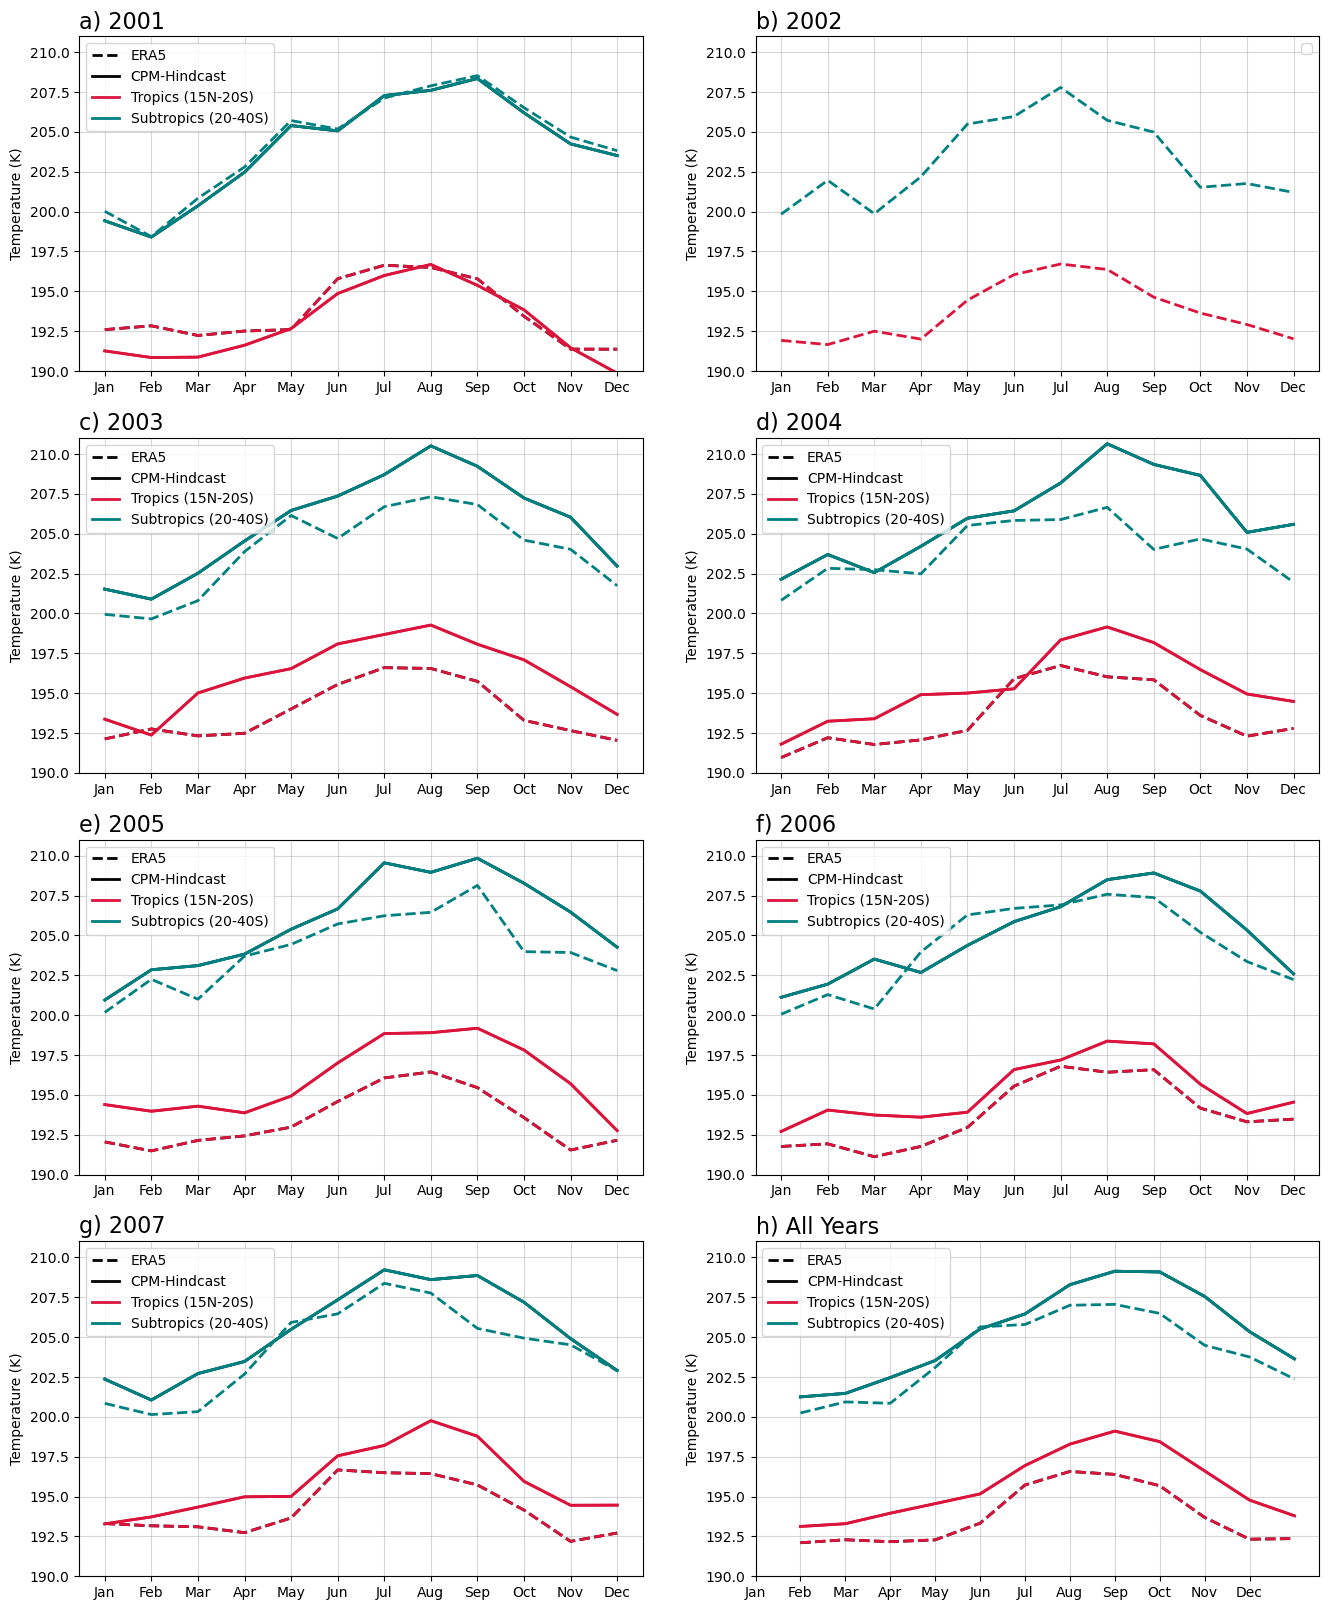

In [96]:
matplotlib.rc_file_defaults()

plt.figure(figsize=(16,20))
f= 30
lf= 35
l=32

ax1 = plt.subplot(4, 2, 1) 
ax1.plot(trop_temp_tropics_2001, linewidth=2, label='ERA5', color='k', linestyle='dashed') ###
ax1.plot(trop_temp_values_subtropics_2001, label='CPM-Hindcast', linewidth=2, color='k') ###
ax1.plot(trop_temp_values_tropics_2001, label='Tropics (15N-20S)', linewidth=2, color='crimson') ###
ax1.plot(trop_temp_values_subtropics_2001, label='Subtropics (20-40S)', linewidth=2, color='teal') ###
ax1.plot(trop_temp_tropics_2001, linewidth=2, color='crimson', linestyle='dashed')
ax1.plot(trop_temp_values_tropics_2001, linewidth=2, color='crimson')
ax1.plot(trop_temp_subtropics_2001, linewidth=2, color='teal', linestyle='dashed') 
ax1.plot(trop_temp_values_subtropics_2001, linewidth=2, color='teal')
ax1.set_title('a) 2001', fontsize=16, loc='left')
ax1.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax1.set_ylabel('Temperature (K)')
ax1.set_ylim(190,211)
ax1.legend(loc='best')
ax1.grid(alpha=0.5)

ax2.plot(trop_temp_tropics_2002, linewidth=2, label='ERA5', color='k', linestyle='dashed') ###
ax2 = plt.subplot(4, 2, 2) 
#ax2.plot(trop_temp_values_subtropics_2002, label='CPM-Hindcast', linewidth=2, color='k') ###
#ax2.plot(trop_temp_values_tropics_2002, label='Tropics (15N-20S)', linewidth=2, color='crimson') ###
#ax2.plot(trop_temp_values_subtropics_2002, label='Subtropics (20-40S)', linewidth=2, color='teal') ###
ax2.plot(trop_temp_tropics_2002, linewidth=2, color='crimson', linestyle='dashed')
#ax2.plot(trop_temp_values_tropics_2002, linewidth=2, color='crimson')
ax2.plot(trop_temp_subtropics_2002, linewidth=2, color='teal', linestyle='dashed') 
#ax2.plot(trop_temp_values_subtropics_2002, linewidth=2, color='teal')
ax2.set_title('b) 2002', fontsize=16, loc='left')
ax2.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax2.set_ylabel('Temperature (K)')
ax2.set_ylim(190,211)
ax2.legend(loc='best')
ax2.grid(alpha=0.5)

ax3 = plt.subplot(4, 2, 3) 
ax3.plot(trop_temp_tropics_2003, linewidth=2, label='ERA5', color='k', linestyle='dashed') ###
ax3.plot(trop_temp_values_subtropics_2003, label='CPM-Hindcast', linewidth=2, color='k') ###
ax3.plot(trop_temp_values_tropics_2003, label='Tropics (15N-20S)', linewidth=2, color='crimson') ###
ax3.plot(trop_temp_values_subtropics_2003, label='Subtropics (20-40S)', linewidth=2, color='teal') ###
ax3.plot(trop_temp_tropics_2003, linewidth=2, color='crimson', linestyle='dashed')
ax3.plot(trop_temp_values_tropics_2003, linewidth=2, color='crimson')
ax3.plot(trop_temp_subtropics_2003, linewidth=2, color='teal', linestyle='dashed') 
ax3.plot(trop_temp_values_subtropics_2003, linewidth=2, color='teal')
ax3.set_title('c) 2003', fontsize=16, loc='left')
ax3.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax3.set_ylabel('Temperature (K)')
ax3.set_ylim(190,211)
ax3.legend(loc='best')
ax3.grid(alpha=0.5)

ax4 = plt.subplot(4, 2, 4) 
ax4.plot(trop_temp_tropics_2004, linewidth=2, label='ERA5', color='k', linestyle='dashed') ###
ax4.plot(trop_temp_values_subtropics_2004, label='CPM-Hindcast', linewidth=2, color='k') ###
ax4.plot(trop_temp_values_tropics_2004, label='Tropics (15N-20S)', linewidth=2, color='crimson') ###
ax4.plot(trop_temp_values_subtropics_2004, label='Subtropics (20-40S)', linewidth=2, color='teal') ###
ax4.plot(trop_temp_tropics_2004, linewidth=2, color='crimson', linestyle='dashed')
ax4.plot(trop_temp_values_tropics_2004, linewidth=2, color='crimson')
ax4.plot(trop_temp_subtropics_2004, linewidth=2, color='teal', linestyle='dashed') 
ax4.plot(trop_temp_values_subtropics_2004, linewidth=2, color='teal')
ax4.set_title('d) 2004', fontsize=16, loc='left')
ax4.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax4.set_ylabel('Temperature (K)')
ax4.set_ylim(190,211)
ax4.legend(loc='best')
ax4.grid(alpha=0.5)

ax5 = plt.subplot(4, 2, 5) 
ax5.plot(trop_temp_tropics_2005, linewidth=2, label='ERA5', color='k', linestyle='dashed') ###
ax5.plot(trop_temp_values_subtropics_2005, label='CPM-Hindcast', linewidth=2, color='k') ###
ax5.plot(trop_temp_values_tropics_2005, label='Tropics (15N-20S)', linewidth=2, color='crimson') ###
ax5.plot(trop_temp_values_subtropics_2005, label='Subtropics (20-40S)', linewidth=2, color='teal') ###
ax5.plot(trop_temp_tropics_2005, linewidth=2, color='crimson', linestyle='dashed')
ax5.plot(trop_temp_values_tropics_2005, linewidth=2, color='crimson')
ax5.plot(trop_temp_subtropics_2005, linewidth=2, color='teal', linestyle='dashed') 
ax5.plot(trop_temp_values_subtropics_2005, linewidth=2, color='teal')
ax5.set_title('e) 2005', fontsize=16, loc='left')
ax5.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax5.set_ylabel('Temperature (K)')
ax5.set_ylim(190,211)
ax5.legend(loc='best')
ax5.grid(alpha=0.5)

ax6 = plt.subplot(4, 2, 6) 
ax6.plot(trop_temp_tropics_2006, linewidth=2, label='ERA5', color='k', linestyle='dashed') ###
ax6.plot(trop_temp_values_subtropics_2006, label='CPM-Hindcast', linewidth=2, color='k') ###
ax6.plot(trop_temp_values_tropics_2006, label='Tropics (15N-20S)', linewidth=2, color='crimson') ###
ax6.plot(trop_temp_values_subtropics_2006, label='Subtropics (20-40S)', linewidth=2, color='teal') ###
ax6.plot(trop_temp_tropics_2006, linewidth=2, color='crimson', linestyle='dashed')
ax6.plot(trop_temp_values_tropics_2006, linewidth=2, color='crimson')
ax6.plot(trop_temp_subtropics_2006, linewidth=2, color='teal', linestyle='dashed') 
ax6.plot(trop_temp_values_subtropics_2006, linewidth=2, color='teal')
ax6.set_title('f) 2006', fontsize=16, loc='left')
ax6.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax6.set_ylabel('Temperature (K)')
ax6.set_ylim(190,211)
ax6.legend(loc='best')
ax6.grid(alpha=0.5)

ax8 = plt.subplot(4, 2, 7) 
ax8.plot(trop_temp_tropics_2007, linewidth=2, label='ERA5', color='k', linestyle='dashed') ###
ax8.plot(trop_temp_values_subtropics_2007, label='CPM-Hindcast', linewidth=2, color='k') ###
ax8.plot(trop_temp_values_tropics_2007, label='Tropics (15N-20S)', linewidth=2, color='crimson') ###
ax8.plot(trop_temp_values_subtropics_2007, label='Subtropics (20-40S)', linewidth=2, color='teal') ###
ax8.plot(trop_temp_tropics_2007, linewidth=2, color='crimson', linestyle='dashed')
ax8.plot(trop_temp_values_tropics_2007, linewidth=2, color='crimson')
ax8.plot(trop_temp_subtropics_2007, linewidth=2, color='teal', linestyle='dashed') 
ax8.plot(trop_temp_values_subtropics_2007, linewidth=2, color='teal')
ax8.set_title('g) 2007', fontsize=16, loc='left')
ax8.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax8.set_ylabel('Temperature (K)')
ax8.set_ylim(190,211)
ax8.legend(loc='best')
ax8.grid(alpha=0.5)

ax7 = plt.subplot(4, 2, 8) 
ax7.plot(mean_obs_tropics['mean'], linewidth=2, label='ERA5', color='k', linestyle='dashed') ###
ax7.plot(mean_cpm_subtropics['mean'], label='CPM-Hindcast', linewidth=2, color='k') ###
ax7.plot(mean_cpm_tropics['mean'], label='Tropics (15N-20S)', linewidth=2, color='crimson') ###
ax7.plot(mean_cpm_subtropics['mean'], label='Subtropics (20-40S)', linewidth=2, color='teal') ###
ax7.plot(mean_obs_tropics['mean'], linewidth=2, color='crimson', linestyle='dashed')
ax7.plot(mean_cpm_tropics['mean'], linewidth=2, color='crimson')
ax7.plot(mean_obs_subtropics['mean'], linewidth=2, color='teal', linestyle='dashed') 
ax7.plot(mean_cpm_subtropics['mean'], linewidth=2, color='teal')
ax7.set_title('h) All Years', fontsize=16, loc='left')
ax7.set_xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax7.set_ylabel('Temperature (K)')
ax7.set_ylim(190,211)
ax7.legend(loc='best')
ax7.grid(alpha=0.5)

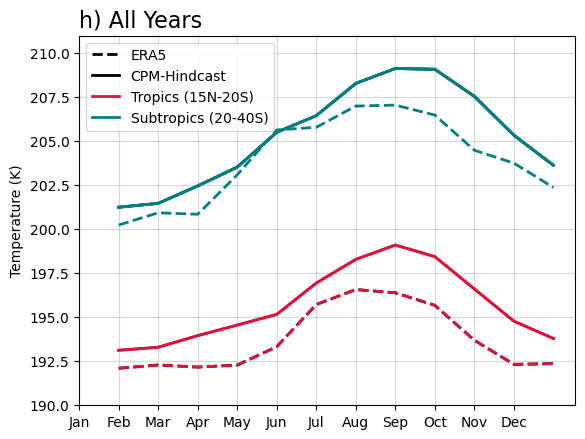

In [95]:

plt.plot(mean_obs_tropics['mean'], linewidth=2, label='ERA5', color='k', linestyle='dashed') ###
plt.plot(mean_cpm_subtropics['mean'], label='CPM-Hindcast', linewidth=2, color='k') ###
plt.plot(mean_cpm_tropics['mean'], label='Tropics (15N-20S)', linewidth=2, color='crimson') ###
plt.plot(mean_cpm_subtropics['mean'], label='Subtropics (20-40S)', linewidth=2, color='teal') ###
plt.plot(mean_obs_tropics['mean'], linewidth=2, color='crimson', linestyle='dashed')
plt.plot(mean_cpm_tropics['mean'], linewidth=2, color='crimson')
plt.plot(mean_obs_subtropics['mean'], linewidth=2, color='teal', linestyle='dashed') 
plt.plot(mean_cpm_subtropics['mean'], linewidth=2, color='teal')
plt.title('h) All Years', fontsize=16, loc='left')
plt.xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Temperature (K)')
plt.ylim(190,211)
plt.legend(loc='best')
plt.grid(alpha=0.5)

**Testing to see how much the tropopause temp varies at different times of day (i.e. plotting the tropopause temp for when using different hours of the 1st day)**

In [35]:
filename_cpm = '/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/cpm_airtemp.nc'

cpm_airtemp = xr.open_dataset(filename_cpm)

cpm_airtemp = cpm_airtemp.air_temperature

cpm_airtemp_3 = cpm_airtemp[cpm_airtemp.time.dt.hour == 3] ##subsetting for first hour of each month
cpm_airtemp_6 = cpm_airtemp[cpm_airtemp.time.dt.hour == 6] ##subsetting for first hour of each month
cpm_airtemp_9 = cpm_airtemp[cpm_airtemp.time.dt.hour == 9] ##subsetting for first hour of each month
cpm_airtemp_12 = cpm_airtemp[cpm_airtemp.time.dt.hour == 12] ##subsetting for first hour of each month


In [36]:
cpm_airtemp_3.time

<xarray.DataArray 'time' (time: 12)>
array(['2001-01-01T03:00:00.000000000', '2001-02-01T03:00:00.000000000',
       '2001-03-01T03:00:00.000000000', '2001-04-01T03:00:00.000000000',
       '2001-05-01T03:00:00.000000000', '2001-06-01T03:00:00.000000000',
       '2001-07-01T03:00:00.000000000', '2001-08-01T03:00:00.000000000',
       '2001-09-01T03:00:00.000000000', '2001-10-01T03:00:00.000000000',
       '2001-11-01T03:00:00.000000000', '2001-12-01T03:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time                     (time) datetime64[ns] 2001-01-01T03:00:00 ... 20...
    forecast_period          (time) timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
Attributes:
    axis:           T
    standard_name:  time

In [37]:
cpm_airtemp_3_y = cpm_airtemp_3.groupby('time').mean('longitude') ##zonal mean at each time and height
cpm_airtemp_3_z = cpm_airtemp_3_y.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

cpm_airtemp_6_y = cpm_airtemp_6.groupby('time').mean('longitude') ##zonal mean at each time and height
cpm_airtemp_6_z = cpm_airtemp_6_y.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

cpm_airtemp_9_y = cpm_airtemp_9.groupby('time').mean('longitude') ##zonal mean at each time and height
cpm_airtemp_9_z = cpm_airtemp_9_y.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

cpm_airtemp_12_y = cpm_airtemp_12.groupby('time').mean('longitude') ##zonal mean at each time and height
cpm_airtemp_12_z = cpm_airtemp_12_y.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

In [38]:
## LOOP TO FIND THE TROPOAUSE TEMP FOR EACH MONTH - ERA5 TROPICS ##

trop_temp_3 = []

for month in np.arange(0,12):
    subset = cpm_airtemp_3_z.isel(time = month)
    min_3 = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min_3)
    trop_temp_3.append(float(min_3))

193.99614
194.2491
194.65756
195.81245
195.6181
197.76918
198.8907
200.98793
200.1964
199.4544
196.6274
195.57085


In [39]:
trop_temp_6 = []

for month in np.arange(0,12):
    subset = cpm_airtemp_6_z.isel(time = month)
    min_6 = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min_6)
    trop_temp_6.append(float(min_6))

193.85965
194.16338
194.63567
195.79419
195.5822
197.73235
198.93538
200.93883
200.15823
199.4764
196.63562
195.4837


In [40]:
trop_temp_9 = []

for month in np.arange(0,12):
    subset = cpm_airtemp_9_z.isel(time = month)
    min_9 = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min_9)
    trop_temp_9.append(float(min_9))

193.91261
194.1326
194.72311
195.87854
195.66501
197.80182
199.03842
200.96751
200.23273
199.52815
196.735
195.55255


In [41]:
trop_temp_12 = []

for month in np.arange(0,12):
    subset = cpm_airtemp_12_z.isel(time = month)
    min_12 = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min_12)
    trop_temp_12.append(float(min_12))

194.12587
194.26085
194.9559
196.06824
195.90651
197.99393
199.24202
201.07936
200.45609
199.7099
197.05228
195.77371


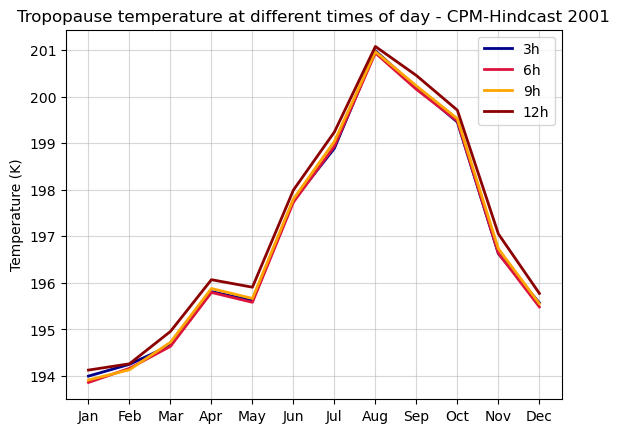

In [42]:
## Plot to compare tropopause temps between ERA5 (monthly mean) and the CPM-Hindcast(1st hr of each month)

plt.plot(trop_temp_3, label='3h',linewidth=2, color='darkblue')
plt.plot(trop_temp_6, label='6h',linewidth=2, color='crimson')
plt.plot(trop_temp_9, label='9h',linewidth=2, color='orange')
plt.plot(trop_temp_12, label='12h',linewidth=2, color='darkred')
plt.title('Tropopause temperature at different times of day - CPM-Hindcast 2001')
plt.xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Temperature (K)')
plt.legend(loc='best')
plt.grid(alpha=0.5)

**Putting the values into a pandas dataframe to more easily calculate mean**

In [43]:
cpm_airtemp_hours = pd.DataFrame()
cpm_airtemp_hours['3h'] = np.zeros(12)
cpm_airtemp_hours['6h'] = np.zeros(12)
cpm_airtemp_hours['9h'] = np.zeros(12)
cpm_airtemp_hours['12h'] = np.zeros(12)


In [44]:
cpm_airtemp_hours

,3h,6h,9h,12h
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0


In [45]:
cpm_airtemp_hours['3h'] = trop_temp_3



In [46]:
cpm_airtemp_hours['6h'] = trop_temp_6
cpm_airtemp_hours['9h'] = trop_temp_9
cpm_airtemp_hours['12h'] = trop_temp_12


In [47]:
cpm_airtemp_hours.iloc[0].mean()

193.97356796264648

In [48]:
i = 0
cpm_airtemp_hours['mean'] = np.nan

for i in np.arange(0,12):
    print(i)
    mean = cpm_airtemp_hours.iloc[i].mean()
    print(mean)
    cpm_airtemp_hours['mean'].iloc[i] = mean
    print()
    i = i+1

0
193.97356796264648

1
194.20148086547852

2
194.74306106567383

3
195.88835525512695

4
195.69295501708984

5
197.8243179321289

6
199.02663040161133

7
200.993408203125

8
200.26086044311523

9
199.5422134399414

10
196.7625732421875

11
195.5952033996582



In [49]:
cpm_airtemp_hours

,3h,6h,9h,12h,mean
0,193.996140,193.859650,193.912613,194.125870,193.973568
1,194.249100,194.163376,194.132599,194.260849,194.201481
2,194.657562,194.635666,194.723114,194.955902,194.743061
3,195.812454,195.794189,195.878540,196.068237,195.888355
4,195.618103,195.582199,195.665009,195.906509,195.692955
5,197.769180,197.732346,197.801819,197.993927,197.824318
6,198.890701,198.935379,199.038422,199.242020,199.026630
7,200.987930,200.938828,200.967514,201.079361,200.993408
8,200.196396,200.158234,200.232727,200.456085,200.260860
9,199.454407,199.476395,199.528152,199.709900,199.542213


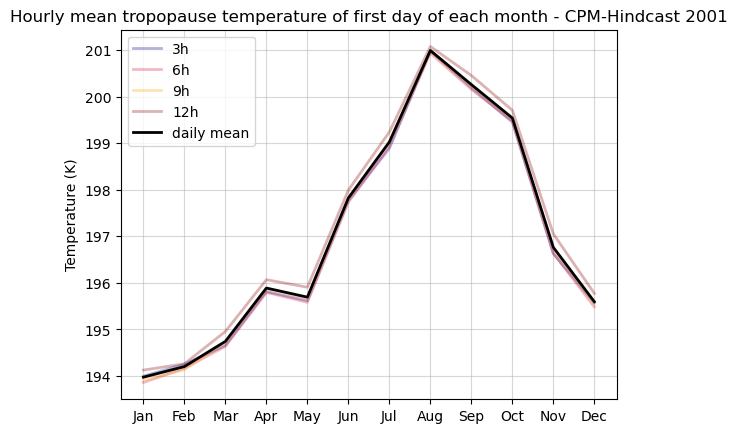

In [50]:
plt.plot(trop_temp_3, label='3h',linewidth=2, color='darkblue', alpha=0.3)
plt.plot(trop_temp_6, label='6h',linewidth=2, color='crimson', alpha=0.3)
plt.plot(trop_temp_9, label='9h',linewidth=2, color='orange', alpha=0.3)
plt.plot(trop_temp_12, label='12h',linewidth=2, color='darkred', alpha=0.3)
plt.plot(cpm_airtemp_hours['mean'], linewidth=2, color='k', label = 'daily mean')
plt.title('Hourly mean tropopause temperature of first day of each month - CPM-Hindcast 2001')
plt.xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Temperature (K)')
plt.legend(loc='best')
plt.grid(alpha=0.5)

### Testing variation in tropopause temp within 1 month (Jan 2001) ###

In [51]:
jan_2001 = xr.open_dataset('/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/jan_2001_cpm_airtemp.nc')
jan_2001 = jan_2001.air_temperature
jan_2001

<xarray.DataArray 'air_temperature' (time: 248, model_level_number: 63,
                                     latitude: 1360, longitude: 1360)>
[28898150400 values with dtype=float32]
Coordinates:
  * time                     (time) datetime64[ns] 2001-01-01 ... 2001-01-31T...
  * model_level_number       (model_level_number) int32 1 2 3 4 ... 60 61 62 63
  * latitude                 (latitude) float32 -40.04 -40.0 ... 14.96 15.0
  * longitude                (longitude) float32 275.0 275.0 ... 330.0 330.0
    forecast_period          (time) timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
    level_height             (model_level_number) float32 ...
    sigma                    (model_level_number) float32 ...
Attributes:
    standard_name:    air_temperature
    units:            K
    um_stash_source:  m01s16i004
    grid_mapping:     latitude_longitude

In [62]:
jan_2001_y = jan_2001.groupby('time').mean('longitude') ##zonal mean at each time and height
jan_2001_z = jan_2001_y.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single vertical profile for each month
jan_2001_z  ## this provides a vertical profile of temperature at each timestep (averaged by latitude and longitude)

<xarray.DataArray 'air_temperature' (time: 248, model_level_number: 63)>
array([[297.40863, 297.42258, 297.36554, ..., 198.61758, 201.98636,
        205.23077],
       [296.5322 , 296.55045, 296.5033 , ..., 198.61154, 202.03061,
        205.27417],
       [295.89056, 295.9009 , 295.8517 , ..., 198.6713 , 202.11714,
        205.33925],
       ...,
       [298.09088, 297.77087, 297.4486 , ..., 201.28732, 204.23259,
        206.79733],
       [299.1722 , 298.86826, 298.5552 , ..., 201.06512, 203.95952,
        206.50381],
       [298.7229 , 298.55658, 298.3298 , ..., 200.77238, 203.64177,
        206.22728]], dtype=float32)
Coordinates:
  * time                     (time) datetime64[ns] 2001-01-01 ... 2001-01-31T...
  * model_level_number       (model_level_number) int32 1 2 3 4 ... 60 61 62 63
    forecast_period          (time) timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
    level_height             (model_level_number) float32 ...
    sigma                    (model_level_number) float32 ...
Attributes:
    standard_name:    air_temperature
    units:            K
    um_stash_source:  m01s16i004
    grid_mapping:     latitude_longitude

In [63]:
jan_2001_z.time

<xarray.DataArray 'time' (time: 248)>
array(['2001-01-01T00:00:00.000000000', '2001-01-01T03:00:00.000000000',
       '2001-01-01T06:00:00.000000000', ..., '2001-01-31T15:00:00.000000000',
       '2001-01-31T18:00:00.000000000', '2001-01-31T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time                     (time) datetime64[ns] 2001-01-01 ... 2001-01-31T...
    forecast_period          (time) timedelta64[ns] ...
    forecast_reference_time  datetime64[ns] ...
Attributes:
    axis:           T
    standard_name:  time

In [69]:
subset = jan_2001_z[jan_2001_z.time.dt.day == 12]
subset
min_cpm = subset.where(subset == subset.min(), drop=True).squeeze().data
print(min_cpm)


194.08153


In [70]:
min_per_day = []

for day in np.unique(jan_2001_z.time.dt.day):
    print(day)
    subset = jan_2001_z[jan_2001_z.time.dt.day == day] #taking a subset of jan 2001 for just a single day at a time
    
    min_cpm = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min_cpm)
    min_per_day.append(float(min_cpm))

1
193.85965
2
193.96216
3
193.94096
4
193.60535
5
193.55028
6
193.88594
7
193.8754
8
193.50203
9
193.55692
10
193.73625
11
194.20903
12
194.08153
13
194.00287
14
194.1665
15
194.24564
16
193.91039
17
193.54025
18
193.78835
19
194.10506
20
194.39938
21
195.19759
22
195.3471
23
195.15517
24
194.90785
25
194.63782
26
194.24236
27
193.40593
28
192.9267
29
192.89871
30
193.20004
31
194.07831


In [71]:
min_per_day

[193.85964965820312,
 193.962158203125,
 193.9409637451172,
 193.6053466796875,
 193.55027770996094,
 193.8859405517578,
 193.87539672851562,
 193.5020294189453,
 193.55691528320312,
 193.7362518310547,
 194.2090301513672,
 194.08152770996094,
 194.00286865234375,
 194.16650390625,
 194.24563598632812,
 193.91038513183594,
 193.54025268554688,
 193.78834533691406,
 194.1050567626953,
 194.39938354492188,
 195.1975860595703,
 195.34710693359375,
 195.15516662597656,
 194.90785217285156,
 194.6378173828125,
 194.2423553466797,
 193.4059295654297,
 192.92669677734375,
 192.89871215820312,
 193.20004272460938,
 194.07830810546875]

In [73]:
np.arange(0,32)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [113]:
np.mean(min_per_day)

193.99746753323464

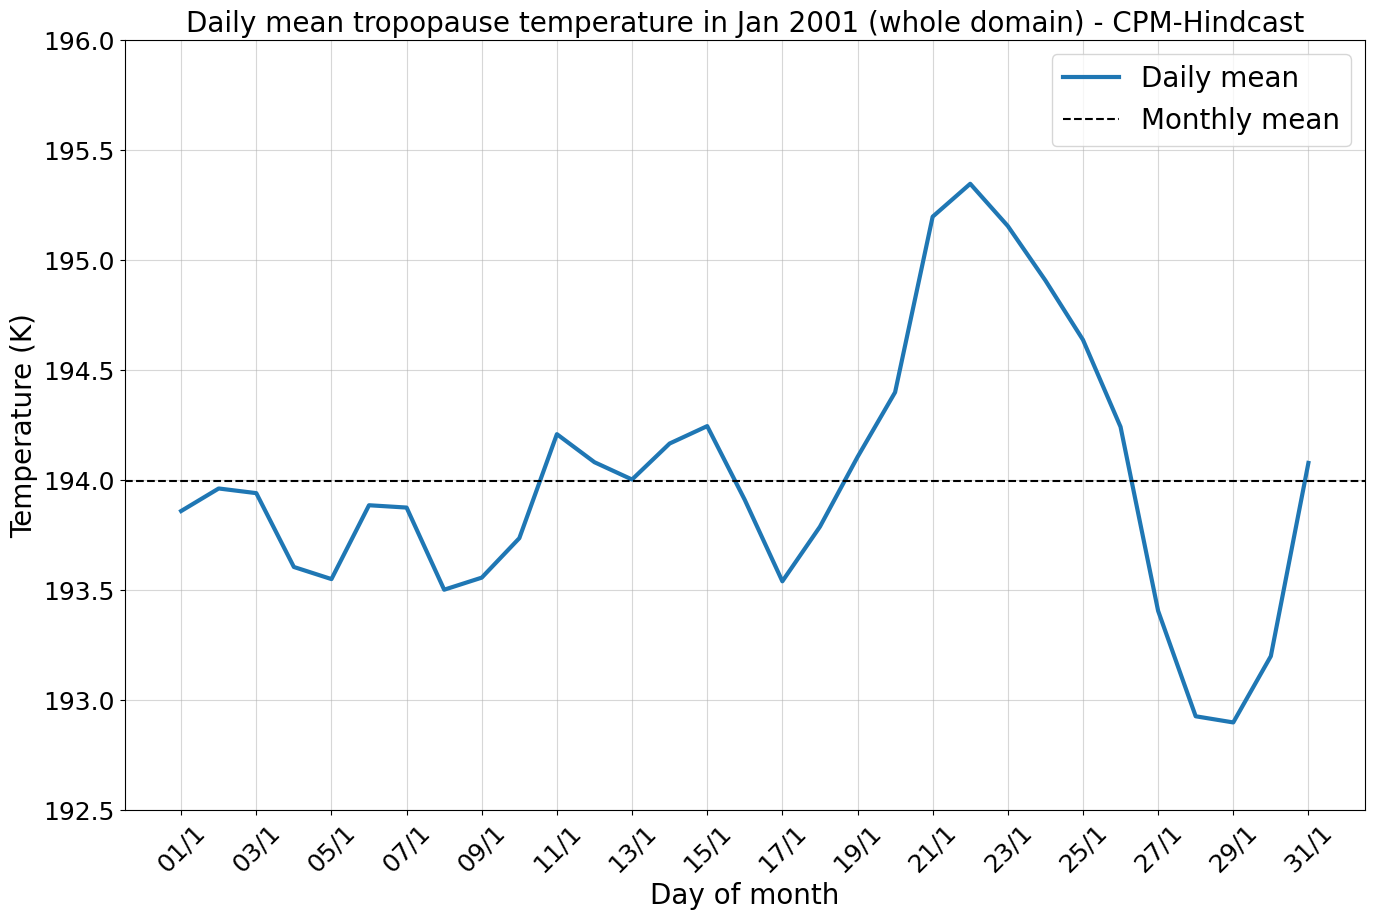

In [125]:
plt.figure(figsize=(16,10))
plt.plot(np.arange(1,32), min_per_day, label='Daily mean', linewidth=3)
plt.axhline(np.mean(min_per_day), linestyle='dashed',color='k', label='Monthly mean')
plt.title('Daily mean tropopause temperature in Jan 2001 (whole domain) - CPM-Hindcast', fontsize=20)
plt.xticks(np.arange(1,32,2), ['01/1','03/1','05/1','07/1','09/1','11/1','13/1','15/1','17/1','19/1','21/1','23/1','25/1','27/1','29/1','31/1'], fontsize=18, rotation=45)
plt.yticks(np.arange(192.5,196.5, 0.5), fontsize=18)
plt.ylabel('Temperature (K)', fontsize=20)
plt.xlabel('Day of month', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.grid(alpha=0.5)

In [28]:
import xarray as xr

filename = '/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/adaptor.mars.internal-1702987416.749182-24150-15-54ec278b-b39b-4b40-a134-6ee2e2766dd4.nc'

era5_airtemp_2002_07 = xr.open_dataset(filename)

filename_01 = '/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/era5_air_temp_w_height.nc'

era5_airtemp_2001 = xr.open_dataset(filename_01)

era5_airtemp_2001 = era5_airtemp_2001.t


In [15]:
era5_airtemp_2002_07 = era5_airtemp_2002_07.t

In [30]:
era5_airtemp_2001_dy = era5_airtemp_2001.groupby('time').mean('longitude') ##zonal mean at each time and height
era5_airtemp_2001_dz = era5_airtemp_2001_dy.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

In [19]:
era5_airtemp_2002_07_dy = era5_airtemp_2002_07.groupby('time').mean('longitude') ##zonal mean at each time and height
era5_airtemp_2002_07_dz = era5_airtemp_2002_07_dy.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

In [20]:
era5_airtemp_2002_07_dz

<xarray.DataArray 't' (time: 72, level: 37)>
array([[262.31967, 259.93887, 253.14264, ..., 293.73764, 295.2447 ,
        296.9667 ],
       [263.5066 , 261.28125, 253.48105, ..., 293.72012, 295.2582 ,
        296.99335],
       [263.433  , 263.59335, 256.01917, ..., 294.01587, 295.53726,
        297.26697],
       ...,
       [266.0576 , 263.19852, 253.50786, ..., 292.1629 , 293.6504 ,
        295.3576 ],
       [265.14224, 263.49695, 255.13463, ..., 292.3308 , 293.87433,
        295.60098],
       [264.8505 , 261.21747, 253.23897, ..., 292.92975, 294.43866,
        296.1602 ]], dtype=float32)
Coordinates:
  * level    (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time     (time) datetime64[ns] 2002-01-01 2002-02-01 ... 2007-12-01
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [33]:
## LOOP TO FIND THE TROPOAUSE TEMP FOR ERA5 ##

trop_temp_obs = []

for month in np.arange(0,12):
    subset = era5_airtemp_2001_dz.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min)
    trop_temp_obs.append(float(min))

195.28645
194.8638
195.34857
196.2358
197.34549
199.19095
200.43205
200.62376
200.39911
198.17285
196.19205
195.94891


In [34]:


for year in np.arange(2002,2008):
    for month in np.arange(0,12):
        subset = era5_airtemp_2002_07_dz[era5_airtemp_2002_07_dz.time.dt.year == year]
        subset = subset.isel(time = month)
        min = subset.where(subset == subset.min(), drop=True).squeeze().data
        print(min)
        trop_temp_obs.append(float(min))
        
        

195.25166
195.42737
195.21227
195.79524
198.46603
199.6145
200.66237
199.78706
198.30562
196.60478
196.22946
195.44843
195.42395
195.23872
195.3816
196.6525
198.39505
198.82356
200.23982
200.459
199.72688
197.39218
196.82478


195.60764
194.90894
196.07892
196.09398
195.88037
197.44656
199.4176
200.03053
199.93906
198.80292
197.62308
196.62648
196.27875
195.25081
195.8189
195.41548
196.58646
197.1231
198.5276
199.74466
200.02649
200.03609
197.40198
196.19098
196.07898
194.74307
195.3173
194.49533
196.20941
197.76031
199.58185
200.43027
200.50313
200.49374
198.21248
197.04306
196.67139
196.54634
195.69853
195.74588
196.44089
198.14395
200.25545
200.81427
200.57887
199.39723
198.11754
196.75972
196.42633


In [55]:
trop_temp_obs[12:24]

[195.2516632080078,
 195.4273681640625,
 195.21226501464844,
 195.7952423095703,
 198.46603393554688,
 199.614501953125,
 200.66236877441406,
 199.7870635986328,
 198.3056182861328,
 196.6047821044922,
 196.22946166992188,
 195.44842529296875]

In [47]:
import pandas as pd
trop_temp_obs_df = pd.DataFrame(columns=['2001', '2002', '2003', '2004', '2005', '2006', '2007'])
#trop_temp_obs_df.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#trop_temp_obs[:12]

In [56]:
trop_temp_obs_df['2001'] = trop_temp_obs[:12]
trop_temp_obs_df['2002'] = trop_temp_obs[12:24]
trop_temp_obs_df['2003'] = trop_temp_obs[24:36]
trop_temp_obs_df['2004'] = trop_temp_obs[36:48]
trop_temp_obs_df['2005'] = trop_temp_obs[48:60]
trop_temp_obs_df['2006'] = trop_temp_obs[60:72]
trop_temp_obs_df['2007'] = trop_temp_obs[72:84]






In [57]:
trop_temp_obs_df

,2001,2002,2003,2004,2005,2006,2007
0,195.286453,195.251663,195.423950,194.908936,195.250809,194.743073,196.546341
1,194.863800,195.427368,195.238724,196.078918,195.818893,195.317307,195.698532
2,195.348572,195.212265,195.381607,196.093979,195.415482,194.495331,195.745880
3,196.235794,195.795242,196.652496,195.880371,196.586456,196.209412,196.440887
4,197.345490,198.466034,198.395050,197.446564,197.123093,197.760315,198.143951
5,199.190948,199.614502,198.823563,199.417603,198.527603,199.581848,200.255447
6,200.432053,200.662369,200.239822,200.030533,199.744659,200.430267,200.814270
7,200.623764,199.787064,200.459000,199.939056,200.026489,200.503128,200.578873
8,200.399109,198.305618,199.726883,198.802917,200.036087,200.493744,199.397232
9,198.172852,196.604782,197.392181,197.623077,197.401978,198.212479,198.117538


In [63]:
for i in np.arange(0,12):
    trop_temp_obs_df['monthly_mean'].iloc[i] = trop_temp_obs_df.iloc[i].mean()

In [64]:
trop_temp_obs_df

,2001,2002,2003,2004,2005,2006,2007,monthly_mean
0,195.286453,195.251663,195.423950,194.908936,195.250809,194.743073,196.546341,195.344461
1,194.863800,195.427368,195.238724,196.078918,195.818893,195.317307,195.698532,195.473500
2,195.348572,195.212265,195.381607,196.093979,195.415482,194.495331,195.745880,195.379697
3,196.235794,195.795242,196.652496,195.880371,196.586456,196.209412,196.440887,196.143140
4,197.345490,198.466034,198.395050,197.446564,197.123093,197.760315,198.143951,197.503120
5,199.190948,199.614502,198.823563,199.417603,198.527603,199.581848,200.255447,198.844497
6,200.432053,200.662369,200.239822,200.030533,199.744659,200.430267,200.814270,199.712304
7,200.623764,199.787064,200.459000,199.939056,200.026489,200.503128,200.578873,199.657729
8,200.399109,198.305618,199.726883,198.802917,200.036087,200.493744,199.397232,199.063256
9,198.172852,196.604782,197.392181,197.623077,197.401978,198.212479,198.117538,197.358668


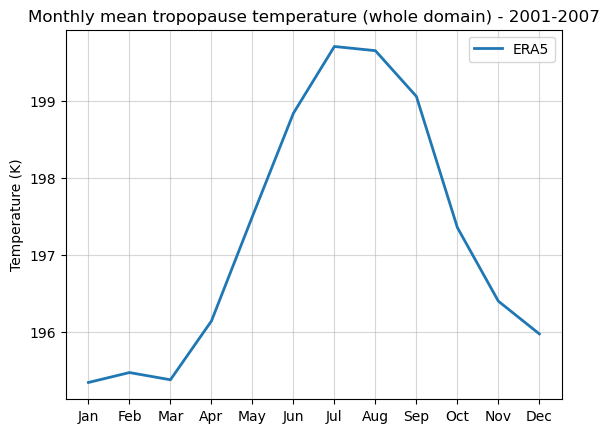

In [71]:
import matplotlib.pyplot as plt

plt.plot(trop_temp_obs_df.monthly_mean, label='ERA5', linewidth=2)
plt.title('Monthly mean tropopause temperature (whole domain) - 2001-2007')
plt.xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Temperature (K)')
plt.legend(loc='best')
plt.grid(alpha=0.5)
plt.savefig('monthly_mean_tropopause_temp.png')